In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams
rcParams["figure.max_open_warning"] = False

In [2]:
sys.path.append('../crazyflie-audio/python/')
from bin_selection import select_frequencies
from crazyflie_description_py.parameters import N_BUFFER, FS, FFTSIZE

DURATION_PER_FREQ = 0.5 
DURATION_SEC = DURATION_PER_FREQ * FFTSIZE
print(DURATION_SEC)

def buzzer_signal(source):
    from signals import generate_signal
    kwargs = dict(
        duration_sec=DURATION_SEC, 
        max_dB=-10,
        Fs=FS,
    )
    frequencies = np.fft.rfftfreq(N_BUFFER, 1/FS)
    if source == 'mono4125':
        return generate_signal(signal_type='mono', frequency_hz=4125, **kwargs)
    elif source == 'random':
        return generate_signal(signal_type='random', **kwargs)
    elif source == 'multi':
        phase = np.random.uniform(0, 2*np.pi)
        signal = generate_signal(signal_type='mono', frequency_hz=frequencies[1], **kwargs, phase_offset=phase)
        for f in frequencies[2:]:
            phase = np.random.uniform(0, 2*np.pi)
            signal += generate_signal(signal_type='mono', frequency_hz=f, **kwargs, phase_offset=phase)
        return signal
    elif source == 'sweep':
        # duration of each frequency bin
        min_freq = 100
        max_freq = 4400
        
        bins = select_frequencies(n_buffer=N_BUFFER, fs=FS, min_freq=min_freq, max_freq=max_freq)
        
        duration_all = len(bins) * duration_per_freq
        signal = np.zeros(int(FS * duration_all))
        idx = 0
        for f in frequencies[bins]:
            
            kwargs['duration_sec'] = duration_per_freq
            mono = generate_signal(signal_type='mono', frequency_hz=f, **kwargs)
            signal[idx:idx+len(mono)] = mono
            idx += len(mono)
        return signal
    else:
        raise ValueError(source)
    
signals = {}
for key in ['mono4125', 'random', 'multi', 'sweep']:
    try:
        signal = pd.read_pickle(f'results/{key}.pk')
        print(f'read {key}')
    except:
        signal = buzzer_signal(key)
        pd.to_pickle(signal, f'results/{key}.pk')
        print(f'saved {key}')
    signals[key] = signal

16.0
read mono4125
read random
read multi
read sweep


In [3]:
def matrix_slices(df_matrix, frequencies, distances, saveas='', ymin=None, ymax=None):
    from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
    import ipywidgets as widgets

    def update_figure(slice_f, slice_d):
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(10, 3)
        #axs[0].semilogy(distances, df_matrix[slice_f, :])
        axs[0].plot(distances, df_matrix[slice_f, :])
        axs[0].set_title(f'frequency = {frequencies[slice_f]:.0f} Hz')
        axs[0].set_xlabel('distance [cm]')
        axs[0].set_ylim(ymin, ymax)

        #axs[1].semilogy(frequencies, df_matrix[:, slice_d])
        axs[1].plot(frequencies, df_matrix[:, slice_d])
        axs[1].set_title(f'distance = {distances[slice_d]:.0f} cm')
        axs[1].set_xlabel('frequency [Hz]')
        axs[1].set_ylim(ymin, ymax)
        if saveas != '':
            fig.savefig(saveas, bbox_inches='tight')
        plt.show()

    interactive_plot = interact(update_figure, 
                                slice_f=IntSlider(200, min=0, max=len(frequencies)-1, continuous_update=False), 
                                slice_d=IntSlider(50, min=0, max=len(distances)-1, continuous_update=False))

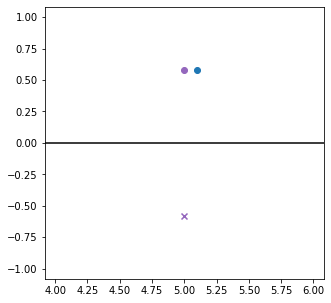

In [4]:
from simulation import generate_room, get_slice

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
room = generate_room(distance_cm=50, yaw_deg=0, ax=ax, single_mic=True)

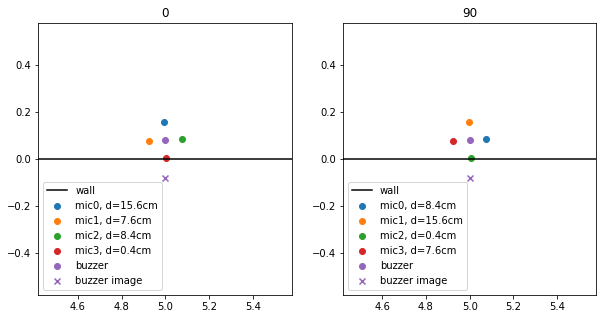

In [5]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
room = generate_room(distance_cm=0, yaw_deg=0, ax=axs[0])
axs[0].set_title(0)
room = generate_room(distance_cm=0, yaw_deg=90, ax=axs[1])
axs[1].set_title(90)
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')

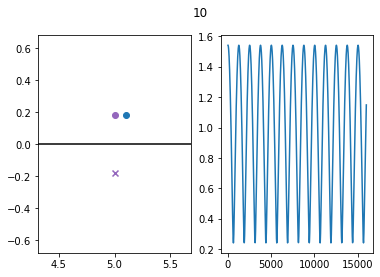

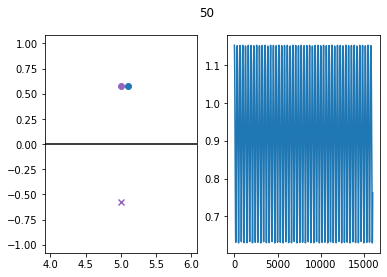

In [6]:
from crazyflie_description_py.parameters import N_BUFFER, FS
frequencies_theo = np.fft.rfftfreq(N_BUFFER, 1/FS)

for distance_cm in [10, 50]:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(distance_cm)
    Hs = get_slice(frequencies_theo, distance_cm=distance_cm, single_mic=True, ax=axs[0])
    for H in Hs:
        axs[1].plot(frequencies_theo, np.abs(H))

In [8]:
room = generate_room(distance_cm=50, single_mic=True)

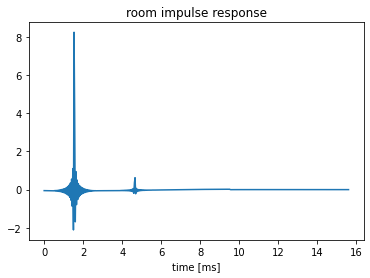

In [9]:
room.compute_rir()

n_times = 500
times = np.arange(n_times) / FS * 1e3
plt.plot(times, room.rir[0][0][:n_times])
plt.title('room impulse response')
plt.xlabel('time [ms]')
plt.show()

# Distance-frequency matrix

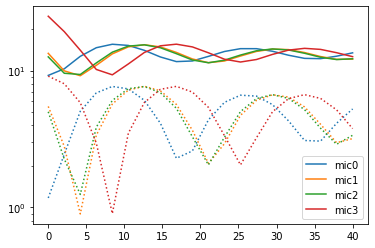

In [10]:
# TODO(FD): below is potentially much faster than frequency slices. 
# consider replacing distance-frequency matrix generation with these. 
from simulation import get_dist_slice_pyroom, get_dist_slice_theory

distances_cm = np.linspace(0, 40, 20)
frequency = 1000
Hs = get_dist_slice_pyroom(frequency, distances_cm=distances_cm)
Hs_theo = get_dist_slice_theory(frequency, distances_cm=distances_cm)
plt.figure()
for i in range(Hs.shape[1]):
    plt.semilogy(distances_cm, Hs[:, i], label=f'mic{i}', ls='-', color=f'C{i}')
    plt.semilogy(distances_cm, Hs_theo[:, i], ls=':', color=f'C{i}')
plt.legend()

In [32]:
from simulation import get_freq_slice_pyroom
import progressbar

distances = np.linspace(0, 60, 60)
frequencies = np.fft.rfftfreq(N_BUFFER, 1/FS)

fname = 'results/df_matrix_pyroom.pkl'
try:
    series_all = pd.read_pickle(fname)
    print('read', fname)
    np.testing.assert_allclose(series_all.distances, distances)
    np.testing.assert_allclose(series_all.frequencies, frequencies)
    df_matrix = series_all.df_matrix
except Exception as e:
    print(e)
    mic_idx = 1
    df_matrix = np.zeros((len(frequencies), len(distances)))
    
    signal = signals['multi']
    with progressbar.ProgressBar(max_value=len(distances)-1) as bar:
        for j, distance_cm in enumerate(distances):
            #room = generate_room(distance_cm=distance_cm, single_mic=True)
            #stft = get_stft(room, signal)
            #spec = np.sum(np.abs(stft), axis=1) / (stft.shape[1] * N_BUFFER) # times x frequencies
            #spec_time_avg = np.mean(spec, axis=0) 
            #df_matrix[:, j] = spec_time_avg
            slice_mics = get_freq_slice_pyroom(frequencies, distance_cm, signal=signal)
            #df_matrix[:, j] = np.mean(slice_mics, axis=0) 
            df_matrix[:, j] = slice_mics[mic_idx]
            bar.update(j)
    series = pd.Series({'df_matrix':df_matrix, 'distances': distances, 'frequencies': frequencies})
    pd.to_pickle(series, fname)
    print('saved as', fname)

read results/df_matrix_pyroom.pkl

Not equal to tolerance rtol=1e-07, atol=0

(shapes (100,), (60,) mismatch)
 x: array([ 0.      ,  0.606061,  1.212121,  1.818182,  2.424242,  3.030303,
        3.636364,  4.242424,  4.848485,  5.454545,  6.060606,  6.666667,
        7.272727,  7.878788,  8.484848,  9.090909,  9.69697 , 10.30303 ,...
 y: array([ 0.      ,  1.016949,  2.033898,  3.050847,  4.067797,  5.084746,
        6.101695,  7.118644,  8.135593,  9.152542, 10.169492, 11.186441,
       12.20339 , 13.220339, 14.237288, 15.254237, 16.271186, 17.288136,...


100% (59 of 59) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


saved as results/df_matrix_pyroom.pkl


In [33]:
from simulation import get_freq_slice_theory
df_matrix_theo = np.empty((len(frequencies), len(distances)))
mic_idx = 0

for j, distance_cm in enumerate(distances):
    slice_mics = get_freq_slice_theory(frequencies, distance_cm)
    df_matrix_theo[:, j] = slice_mics[mic_idx]
    #H = generate_rir(frequencies, distance_cm=distance_cm, single_mic=False)[mic_idx] # 
    #df_matrix_theo[:, j] = np.abs(H)

In [34]:
min_freq = 100
max_freq = 5000
min_dist = 1
max_dist = 50
freq_start = int(min_freq / max(frequencies) * len(frequencies))
freq_end = int(max_freq / max(frequencies) * len(frequencies))
dist_start = int(min_dist / max(distances) * len(distances))
dist_end = int(max_dist / max(distances) * len(distances))

dist = distances[dist_start:dist_end]
freq = frequencies[freq_start:freq_end]

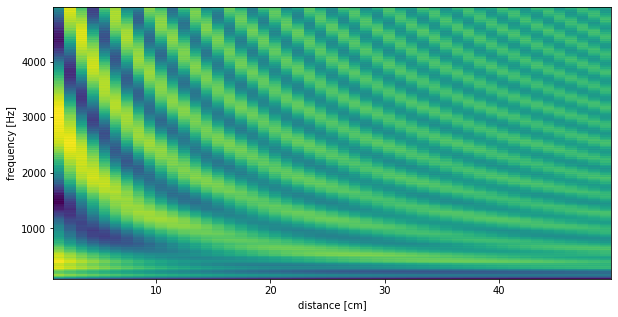

interactive(children=(IntSlider(value=200, continuous_update=False, description='slice_f', max=313), IntSlider…

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.pcolorfast(dist, freq, np.log10(df_matrix[freq_start:freq_end, dist_start:dist_end]))
plt.xlabel('distance [cm]')
plt.ylabel('frequency [Hz]')
fname = 'plots/distance-frequency-matrix.pdf'
fig.savefig(fname, bbox_inches='tight')
fname = 'plots/distance-frequency-matrix-slice.pdf'
matrix_slices(df_matrix[freq_start:freq_end, dist_start:dist_end], freq, dist, saveas=fname)

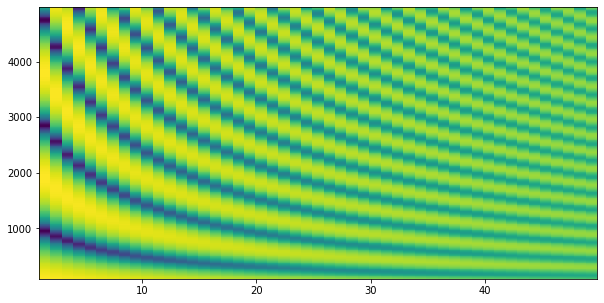

interactive(children=(IntSlider(value=200, continuous_update=False, description='slice_f', max=313), IntSlider…

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.pcolorfast(dist, freq, np.log10(df_matrix_theo[freq_start:freq_end, dist_start:dist_end]))
matrix_slices(df_matrix_theo[freq_start:freq_end, dist_start:dist_end], freq, dist)

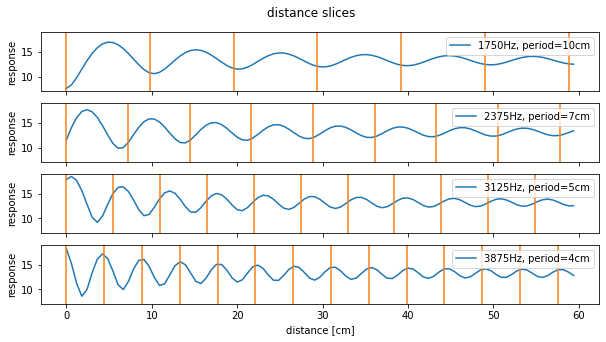

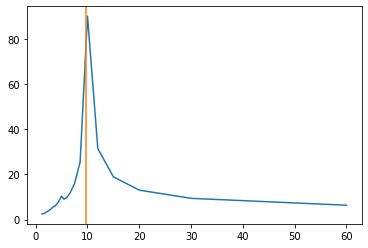

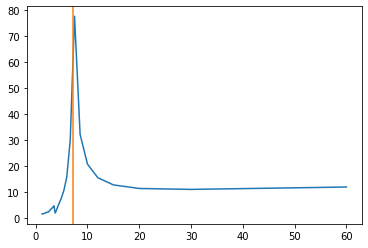

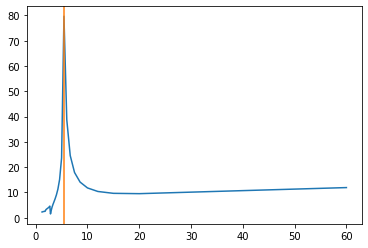

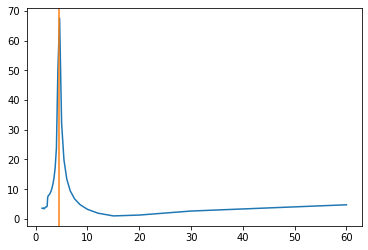

In [26]:
from constants import SPEED_OF_SOUND

#frequencies_slices = [671, 3125, 4156, 8000]
frequencies_slices = [1750, 2375, 3125, 3875]
#frequencies_slices = [703 * (i + 1) for i in range(4)]
#frequencies_slices = [359,  703, 1406]

max_distance = 60
fig, axs = plt.subplots(len(frequencies_slices), sharey=True, sharex=True)
fig.suptitle('distance slices', y=0.95)
fig.set_size_inches(10, 5)
for i, f in enumerate(frequencies_slices):
    idx = np.argmin(np.abs(frequencies-f))
    slice_ = df_matrix[idx, distances < max_distance]
    #slice_ -= np.mean(slice_)
    
    d_constr = SPEED_OF_SOUND / (2 * f) * 100
    axs[i].plot(distances[distances < max_distance], slice_, label=f'{f}Hz, period={d_constr:.0f}cm')
    axs[i].set_ylabel('response')
    axs[i].legend(loc='upper right')
    
    
    # peak from constr. interference is expected when the wavelength equals k * distance/2
    # wavelength_constr = c / f_constr = distance / 2
    num_peaks = (distances[-1]-distances[0])//d_constr + 1
    [axs[i].axvline(x=d, color='C1') for d in np.arange(num_peaks)*d_constr]
    
    fft = np.fft.rfft(slice_)[1:]
    df = distances[1] - distances[0]
    freq = np.fft.rfftfreq(len(slice_), df)[1:]
    plt.figure()
    plt.plot(1/freq, np.abs(fft))
    plt.axvline(d_constr, color='C1')
axs[-1].set_xlabel('distance [cm]')
fig.savefig('plots/distance-frequency-matrix-algorithm.pdf', bbox_inches='tight')

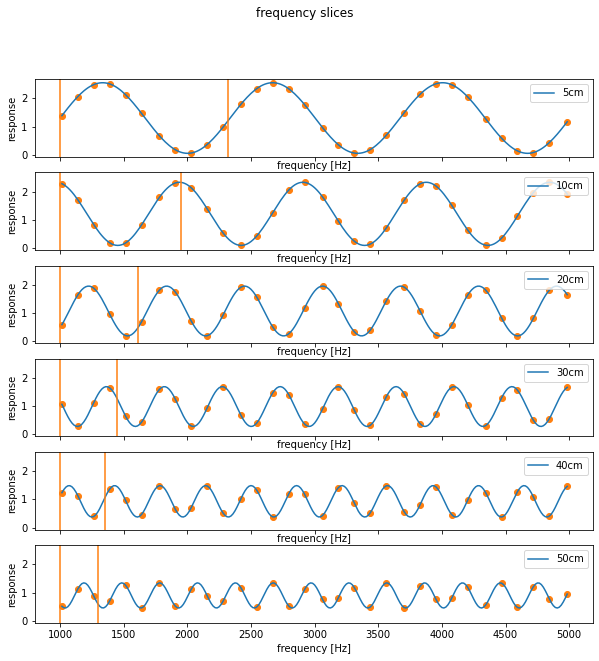

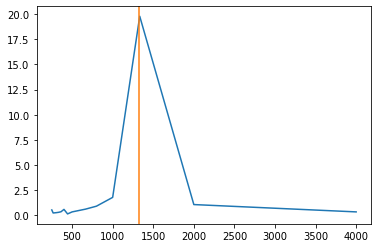

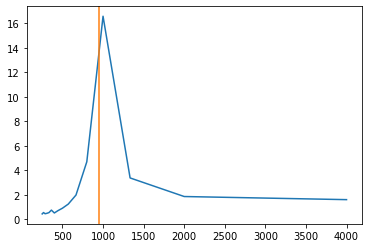

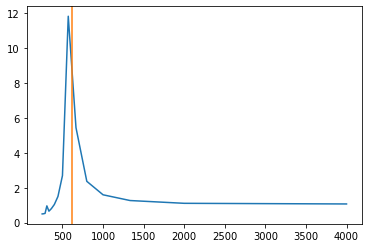

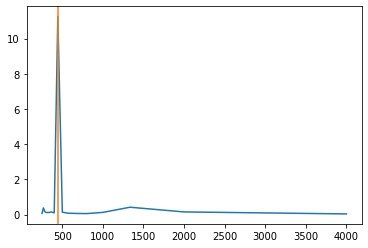

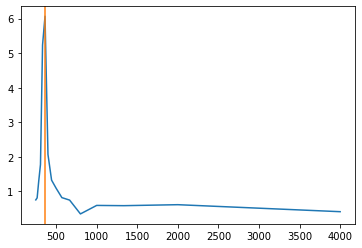

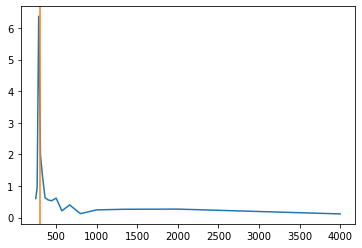

In [29]:
from simulation import get_setup, Y_OFFSET, D0
distance_slices = [5, 10, 20, 30, 40, 50]

max_frequency = 5000
min_frequency = 1000
freq_indices = np.where((frequencies < max_frequency) & (frequencies > min_frequency))[0]
sparse_indices = np.linspace(freq_indices[0], freq_indices[-1], 32).astype(int)


fig, axs = plt.subplots(len(distance_slices), sharey=True, sharex=True)
fig.suptitle('frequency slices')
fig.set_size_inches(10, 10)
for i, d in enumerate(distance_slices):
    idx = np.argmin(np.abs(distances - d))
    slice_ = df_matrix_theo[freq_indices, idx]**2
    axs[i].plot(frequencies[freq_indices], slice_, label=f'{d}cm')
    axs[i].set_xlabel('frequency [Hz]')
    axs[i].set_ylabel('response')
    axs[i].legend(loc='upper right')
    
    slice_ = df_matrix_theo[sparse_indices, idx]**2
    axs[i].scatter(frequencies[sparse_indices], slice_, label=f'{d}cm', color='C1')
    
    source, mic_positions = get_setup(distance_cm=d, single_mic=False)
    source_image = [source[0], -source[1]]
    mic = mic_positions[mic_idx] 
    
    # peak from constr. interference is expected when the wavelength equals k * distance/2
    # wavelength_constr = c / f_constr = distance
    #d1 = 2 * np.sqrt((d * 1e-2 + Y_OFFSET)**2 + D0**2) # m
    #delta = d1 - D0
    delta = np.linalg.norm(source_image - mic) - np.linalg.norm(source - mic)
    
    f_constr = SPEED_OF_SOUND / delta  # Hz
    [axs[i].axvline(x=f+1000, color='C1') for f in np.arange(2)*f_constr]
    
    fft = np.fft.rfft(slice_)[1:]
    df = frequencies[sparse_indices[1]] - frequencies[sparse_indices[0]]
    freq = np.fft.rfftfreq(len(slice_), df)[1:]
    plt.figure()
    plt.plot(1/freq, np.abs(fft))
    plt.axvline(f_constr, color='C1')